In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

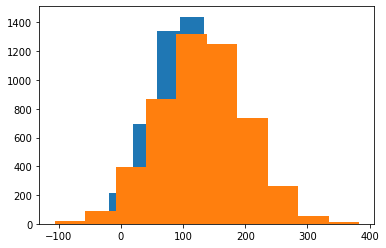

In [114]:
num = 5_000
base = np.random.normal(100, 50, num)
variant = np.random.normal(100, 50, num) + np.random.uniform(1, 2, num)

plt.hist(base_rates);
plt.hist(variant_rates);

In [115]:
print("Scipy p-value:", stats.ttest_ind(base, variant, equal_var=False).pvalue)

Scipy p-value: 0.43888174815397385


In [116]:
effects = [
    (0.1, 0.2),
    (0.5, 1),
    (1, 2),
    (2, 5),
    (5, 10),
    (10, 20)
]
false_positives = []
for min_effect, max_effect in effects:
    fp = 0
    for _ in range(1_000):
        base = np.random.normal(100, 50, num)
        variant = np.random.normal(100, 50, num) + np.random.uniform(min_effect, max_effect, num)
        p_value = stats.ttest_ind(base, variant, equal_var=False).pvalue
        if p_value > 0.05:
            fp += 1
    false_positives.append(fp)
false_positives

[944, 898, 696, 66, 0, 0]

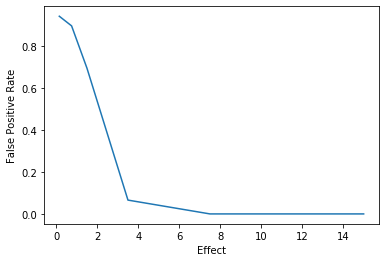

In [117]:
plt.plot([ (a + b) / 2 for a, b in effects ], [ x / 1000 for x in false_positives ])
plt.xlabel("Effect")
plt.ylabel("False Positive Rate");

# Bayesian A/B 

In [118]:
import pymc3 as pm

In [180]:
with pm.Model():
    index = 0
    for min_effect, max_effect in effects:
        base = pm.Normal('base_' + str(index), mu=100, sigma=50)
        variant_no_eff = pm.Normal('variant_no_eff_' + str(index), mu=100, sigma=50)
        effect = pm.Uniform('effect_' + str(index), lower=min_effect, upper=max_effect)
        variant = pm.Deterministic("variant_" + str(index), variant_no_eff + effect)

        delta = pm.Deterministic("delta_" + str(index), variant - base)
        index += 1
    
    trace = pm.sample(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [effect_5, variant_no_eff_5, base_5, effect_4, variant_no_eff_4, base_4, effect_3, variant_no_eff_3, base_3, effect_2, variant_no_eff_2, base_2, effect_1, variant_no_eff_1, base_1, effect_0, variant_no_eff_0, base_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:37<00:00, 563.12draws/s]


For effect between 0.1 and 0.2


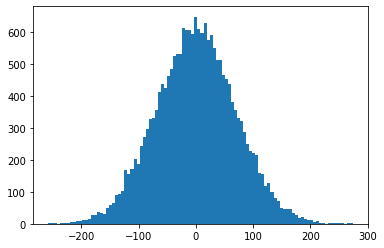

Probability B is BETTER than A: 50.2%
Average effect: 0.2 


For effect between 0.5 and 1


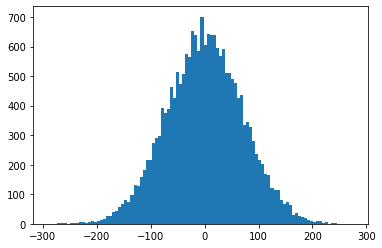

Probability B is BETTER than A: 50.3%
Average effect: 0.2 


For effect between 1 and 2


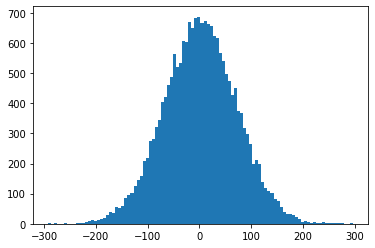

Probability B is BETTER than A: 50.9%
Average effect: 1.9 


For effect between 2 and 5


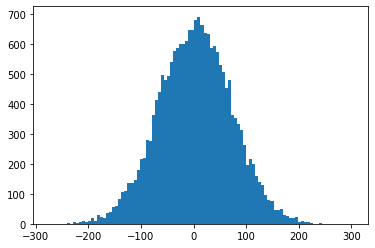

Probability B is BETTER than A: 52.2%
Average effect: 3.2 


For effect between 5 and 10


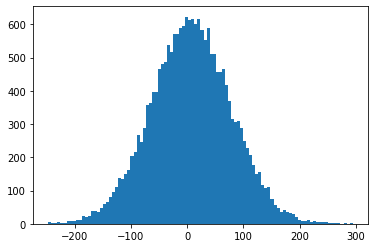

Probability B is BETTER than A: 54.0%
Average effect: 7.1 


For effect between 10 and 20


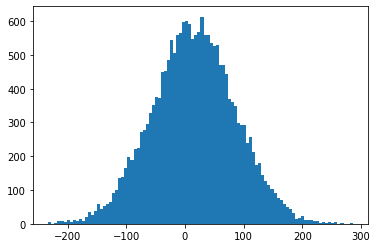

Probability B is BETTER than A: 58.4%
Average effect: 15.0 




In [181]:
index = 0
for min_effect, max_effect in effects:
    print("For effect between", min_effect, "and", max_effect)
    delta = trace["delta_" + str(index)]
    plt.hist(delta, bins=100)
    plt.show()
    print("Probability B is BETTER than A: %.1f%%" % (np.mean(delta > 0) * 100))
    print("Average effect: %.1f" % np.mean(delta), "\n\n")
    index += 1